In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from numpy.random import randn
np.random.seed(0)
import pickle
import gzip
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from geopy.distance import great_circle

In [255]:
# data loading

# NOISE
with gzip.open('../data/segment_with_noise/ll_seg_500_noise.pkl.gzip', 'rb') as f:
    ll_seg_gps_noise = pickle.load(f)
with gzip.open('../data/segment_with_noise/rl_seg_500_noise.pkl.gzip', 'rb') as f:
    rl_seg_gps_noise = pickle.load(f)

# GROUND TRUTH
with gzip.open('../data/segment_groud_truth/rl_seg_gt_500.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open('../data/segment_groud_truth/ll_seg_gt_500.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_gps_noise))
print(ll_seg_gps_noise[0].shape[0])
ll_seg_gps_noise[0].head()

500
77


,y,x,y_norm,x_norm,Vy_norm,Vx_norm,theta_norm,psi_norm,phi_norm,omega_Xv_norm,omega_Yv_norm,alpha_Xv_norm,alpha_Yv_norm,y_norm_noise,x_norm_noise
43567,42.246179,-83.563086,0.786530,0.206384,0.764706,0.778120,0.659098,0.423909,0.453957,0.466896,0.411583,0.508045,0.593818,0.795350,0.203490
43617,42.246167,-83.563112,0.785304,0.204631,0.764706,0.771957,0.658926,0.425454,0.448492,0.418745,0.388417,0.478467,0.536334,0.787305,0.203073
43667,42.246155,-83.563137,0.784089,0.202890,0.764706,0.764253,0.658731,0.431827,0.465695,0.474635,0.473359,0.473024,0.564262,0.788982,0.203170
43717,42.246143,-83.563163,0.782877,0.201164,0.764706,0.758089,0.658551,0.429316,0.485732,0.501290,0.439382,0.472314,0.590835,0.794082,0.195338
43767,42.246131,-83.563188,0.781676,0.199454,0.705882,0.753467,0.658312,0.419467,0.495041,0.423044,0.462548,0.519404,0.539588,0.791014,0.203958


In [282]:
# example segment
exp_rl_seg_gps_noise = rl_seg_gps_noise[91]
print(exp_rl_seg_gps_noise.shape)

(77, 15)


In [53]:
exp_rl_seg_gps_noise.head()

,y,x,y_norm,x_norm,Vy_norm,Vx_norm,theta_norm,psi_norm,phi_norm,omega_Xv_norm,omega_Yv_norm,alpha_Xv_norm,alpha_Yv_norm,y_norm_noise,x_norm_noise
42613,42.246421,-83.562563,0.810921,0.242018,0.823529,0.847458,0.662273,0.322518,0.460231,0.440241,0.444788,0.475154,0.553688,0.810429,0.239551
42663,42.246408,-83.562592,0.809619,0.240080,0.764706,0.847458,0.661768,0.297026,0.433920,0.404987,0.426255,0.445102,0.560466,0.806302,0.237365
42713,42.246395,-83.562620,0.808307,0.238144,0.764706,0.847458,0.661351,0.298185,0.399109,0.404987,0.447876,0.505442,0.606020,0.813940,0.240224
42763,42.246382,-83.562649,0.806994,0.236207,0.764706,0.847458,0.661087,0.333720,0.380085,0.380052,0.449421,0.469475,0.579176,0.801594,0.230426
42813,42.246369,-83.562677,0.805682,0.234273,0.764706,0.844376,0.661029,0.345500,0.390204,0.442820,0.442471,0.472788,0.518709,0.799944,0.238179


In [123]:
np.linspace(0, exp_rl_seg_gps_noise.shape[0] * 50 * 0.01, num=exp_rl_seg_gps_noise.shape[0])

array([ 0.        ,  0.50657895,  1.01315789,  1.51973684,  2.02631579,
        2.53289474,  3.03947368,  3.54605263,  4.05263158,  4.55921053,
        5.06578947,  5.57236842,  6.07894737,  6.58552632,  7.09210526,
        7.59868421,  8.10526316,  8.61184211,  9.11842105,  9.625     ,
       10.13157895, 10.63815789, 11.14473684, 11.65131579, 12.15789474,
       12.66447368, 13.17105263, 13.67763158, 14.18421053, 14.69078947,
       15.19736842, 15.70394737, 16.21052632, 16.71710526, 17.22368421,
       17.73026316, 18.23684211, 18.74342105, 19.25      , 19.75657895,
       20.26315789, 20.76973684, 21.27631579, 21.78289474, 22.28947368,
       22.79605263, 23.30263158, 23.80921053, 24.31578947, 24.82236842,
       25.32894737, 25.83552632, 26.34210526, 26.84868421, 27.35526316,
       27.86184211, 28.36842105, 28.875     , 29.38157895, 29.88815789,
       30.39473684, 30.90131579, 31.40789474, 31.91447368, 32.42105263,
       32.92763158, 33.43421053, 33.94078947, 34.44736842, 34.95

In [235]:
t_norm = MinMaxScaler().fit_transform(np.linspace(0, exp_rl_seg_gps_noise.shape[0] * 50 * 0.01, num=exp_rl_seg_gps_noise.shape[0]).reshape(-1,1)).flatten()
dt = t_norm[1] - t_norm[0]
dt

0.013157894736842105

In [283]:
x_noise = exp_rl_seg_gps_noise['x_norm_noise'].values
y_noise = exp_rl_seg_gps_noise['y_norm_noise'].values
Vx = exp_rl_seg_gps_noise['Vx_norm'].values
Vy = exp_rl_seg_gps_noise['Vy_norm'].values
alpha_Xv = exp_rl_seg_gps_noise['alpha_Xv_norm'].values
alpha_Yv = exp_rl_seg_gps_noise['alpha_Yv_norm'].values

gps_sig = 0.005
# dt = (exp_ll_seg_gps_noise.index[2] - exp_ll_seg_gps_noise.index[1]) * 0.01
d3xdt3 = np.gradient(exp_rl_seg_gps_noise['alpha_Xv_norm'], dt)
d3ydt3 = np.gradient(exp_rl_seg_gps_noise['alpha_Yv_norm'], dt)

A = np.array([
    [1, dt, (dt**2)/2, 0, 0, 0],
    [0, 1, dt, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, dt, (dt**2)/2],
    [0, 0, 0, 0, 1, dt],
    [0, 0, 0, 0, 0, 1],
    ])

Q1 = np.array([(dt**3)/6, (dt**2)/2, dt, 0, 0, 0])
Q1 = np.expand_dims(Q1, 1)
Q2 = np.array([0, 0, 0, (dt**3)/6, (dt**2)/2, dt])
Q2 = np.expand_dims(Q2, 1)

j_var = max(np.var(d3xdt3), np.var(d3ydt3))
Q = j_var * (Q1 @ Q1.T + Q2 @ Q2.T)

H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    ])

R = np.diag(np.array([gps_sig**2, gps_sig**2]))

x_init = np.array([x_noise[0], Vx[0], alpha_Xv[0], y_noise[0], Vy[0], alpha_Yv[0]])
P_init = 0.1 * np.eye(len(x_init))  # small initial prediction error

In [284]:
# create an observation vector of noisy GPS signals
observations = np.array([x_noise, y_noise]).T

# matrix dimensions
nx = Q.shape[0]
ny = R.shape[0]     
nt = observations.shape[0]

# allocate identity matrix for re-use
Inx = np.eye(nx)

# allocate result matrices
x_pred = np.zeros((nt, nx))      # prediction of state vector
P_pred = np.zeros((nt, nx, nx))  # prediction error covariance matrix
x_est = np.zeros((nt, nx))       # estimation of state vector
P_est = np.zeros((nt, nx, nx))   # estimation error covariance matrix
K = np.zeros((nt, nx, ny))       # Kalman Gain

# set initial prediction
x_pred[0] = x_init
P_pred[0] = P_init

for i in range(nt):

    # prediction stage
    if i > 0:
        x_pred[i] = A @ x_est[i-1]
        P_pred[i] = A @ P_est[i-1] @ A.T + Q

    # estimation stage
    y_obs = observations[i]
    K[i] = P_pred[i] @ H.T @ np.linalg.inv((H @ P_pred[i] @ H.T) + R)
    x_est[i] = x_pred[i] + K[i] @ (y_obs - H @ x_pred[i])
    P_est[i] = (Inx - K[i] @ H) @ P_pred[i]

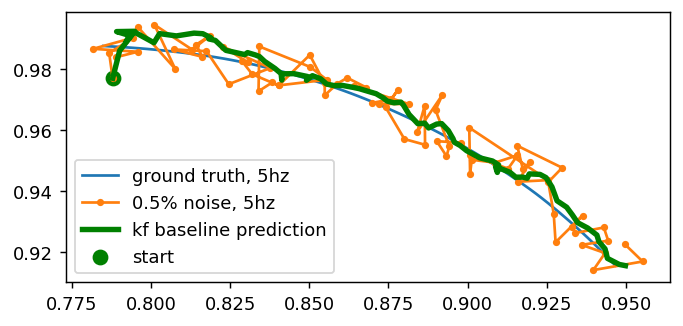

In [298]:
plt.figure(dpi=130, figsize=(6, 2.75))

plt.plot(exp_rl_seg_gps_noise['y_norm'].values, exp_rl_seg_gps_noise['x_norm'].values, label='ground truth, 5hz')
plt.plot(y_noise, x_noise, '-o', label='0.5% noise, 5hz', ms=3)
plt.plot(x_est[:, 3], x_est[:, 0], '-', linewidth=3, label='kf baseline prediction', c='green')
plt.scatter( x_est[:, 3][0], x_est[:, 0][0], label='start', s=60, c='green')

plt.legend()

In [240]:
x_max = -83.55144472
y_max = 42.24829894
x_min = -83.56611364
y_min = 42.23836889

y_exp_test_scale = []
y_exp_noise_scale = []
y_exp_pred_scale = []

# estimation
y_scale = x_est[:, 3] * (y_max - y_min) + y_min
x_scale = x_est[:, 0] * (x_max - x_min) + x_min

coord_scale = np.append(
    y_scale.reshape(77, 1), x_scale.reshape(77, 1), axis=1
)
y_exp_pred_scale.append(coord_scale)

# gt
y_scale = exp_rl_seg_gps_noise['y_norm'].values * (y_max - y_min) + y_min
x_scale = exp_rl_seg_gps_noise['x_norm'].values * (x_max - x_min) + x_min
coord_scale = np.append(
    y_scale.reshape(77, 1), x_scale.reshape(77, 1), axis=1
)
y_exp_test_scale.append(coord_scale)

# noise
y_scale = y_noise * (y_max - y_min) + y_min
x_scale = x_noise * (x_max - x_min) + x_min
coord_scale = np.append(
    y_scale.reshape(77, 1), x_scale.reshape(77, 1), axis=1
)
y_exp_noise_scale.append(coord_scale)

y_test_scale = np.asarray(y_exp_test_scale)
y_pred_scale = np.asarray(y_exp_pred_scale)
y_exp_noise_scale = np.asarray(y_exp_noise_scale)

great_circie_err = []
great_circie_noise_err = []

for traj_i in np.arange(77):
    pred_coord = (y_pred_scale[0][traj_i][0], y_pred_scale[0][traj_i][1])
    actual_coord = (y_test_scale[0][traj_i][0], y_test_scale[0][traj_i][1])
    noise_coord = (y_exp_noise_scale[0][traj_i][0], y_exp_noise_scale[0][traj_i][1])

    great_circie_err.append(great_circle(pred_coord, actual_coord).miles * 1609.34) # meter
    great_circie_noise_err.append(great_circle(noise_coord, actual_coord).miles * 1609.34) # meter

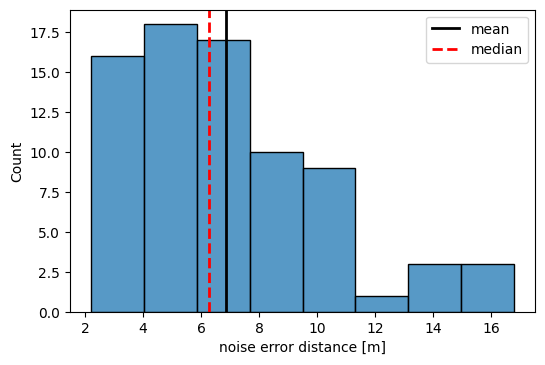

In [241]:
ax = sns.histplot(great_circie_noise_err)
ax.axvline(np.average(great_circie_noise_err), color='k', lw=2, label='mean')
ax.axvline(np.median(great_circie_noise_err), color='red', ls='--', lw=2, label='median')
plt.xlabel('noise error distance [m]')
plt.legend()

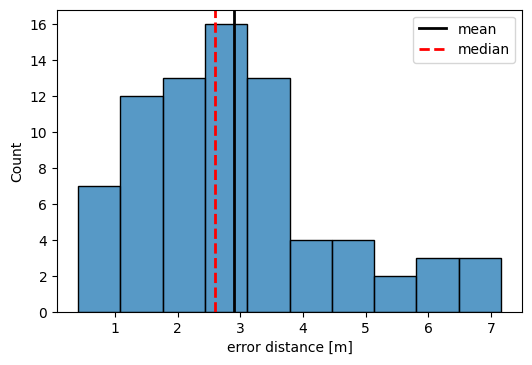

In [242]:
ax = sns.histplot(great_circie_err)
ax.axvline(np.average(great_circie_err), color='k', lw=2, label='mean')
ax.axvline(np.median(great_circie_err), color='red', ls='--', lw=2, label='median')
plt.xlabel('error distance [m]')
plt.legend()

In [251]:
noise = np.random.normal(0, 1, size=(1000, 2)) * 0.005
noise[:,0] = noise[:,0] * (x_max - x_min) + x_min
noise[:,1] = noise[:,1] * (y_max - y_min) + y_min
noise = list(zip(noise[:,0], noise[:,1]))

zeros = np.zeros((1000, 2))
zeros[:,0] = zeros[:,0] * (x_max - x_min) + x_min
zeros[:,1] = zeros[:,1] * (y_max - y_min) + y_min
zeros = list(zip(zeros[:,0], zeros[:,1]))

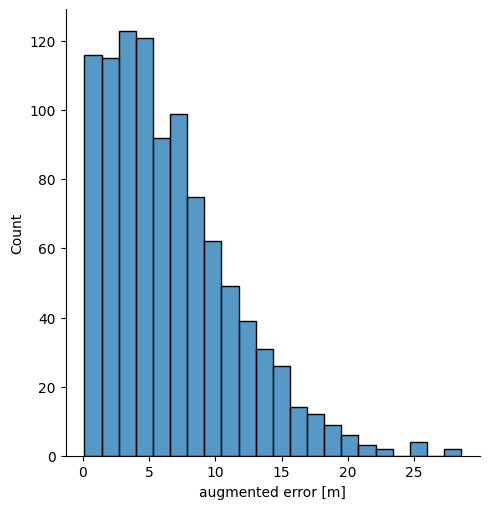

In [277]:
# augmented noise distribution in meters

distances = [great_circle(noise[i], zeros[i]).miles * 1609.34 for i in np.arange(1000)]
sns.displot(distances)
plt.xlabel('augmented error [m]')
plt.show()